In [226]:
import numpy as np
import pandas as pd, datetime as dt
from pandas import read_csv
import seaborn as sn
from matplotlib import pyplot as plt

import seaborn as snscz
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
plt.style.use('seaborn')

In [227]:
# Defining Functions
import pandas as pd

#Following function will, preprocess original dataframe,
#extract features that might have impact on the emergency
#calls weather dataframe
def prepare_weather_data(df, trim=False, startdate=None, enddate=None):
    df.dt_iso = pd.to_datetime(df.dt_iso, format="%Y-%m-%d %H:%M:%S %z UTC")
    df.rename(columns={"dt_iso": "utc_time"}, inplace=True)
    df.insert(1, "local_time", df["utc_time"].dt.tz_convert('US/Pacific'))
    df.set_index('local_time', inplace=True)
    df.sort_index(inplace=True)
    df.index = df.index.tz_localize(None)
    df = df.filter(["temp_max", "wind_speed", "weather_id"])
    if trim == True:
        return df[(df.index >= startdate) & (df.index < enddate)]
    else:
        return df
    
    
def prepare_call_data(df, trim=False, startdate=None, enddate=None):
    df.rename(columns={"Datetime":"local_time"}, inplace=True)
    df.local_time = pd.to_datetime(df.local_time, infer_datetime_format=True)
    df.loc[:, "day"] = pd.to_datetime(df.local_time.dt.strftime("%Y-%m-%d"))
    df.loc[:, "hour"] = pd.to_datetime(df.local_time.dt.strftime("%Y-%m-%d %H:00:00"))
    df.set_index('local_time', inplace=True)
    df.sort_index(inplace=True)
    if trim == True:
        startdate = pd.Timestamp(startdate)
        enddate = pd.Timestamp(enddate)
        return df.filter(["day", "hour"])[(df.index >= startdate) & (df.index < enddate)]
    else:
        return df.filter(["day", "hour"])


def check_duplicate_timestamps(df):
    if df.index.duplicated().any():
        print(f"Found {df[df.index.duplicated()].shape[0]} duplicates, keeping latest row!")
        return df[~df.index.duplicated(keep='last')]
    else: 
        print(f"No duplicates found in dataframe! Proceed...")
        return df


def count_hourly_calls(df):
    h = df.hour.value_counts()
    h.sort_index(inplace=True)
    h.index.name = 'hour'
    return pd.DataFrame(h).rename(columns={"hour":"counts"})

def count_daily_calls(df):
    d = df.day.value_counts()
    d.sort_index(inplace=True)
    d.index.name = 'day'
    return pd.DataFrame(d).rename(columns={"day":"counts"})

def fill_missing_hours(df):
    N_hours = pd.date_range(start=df.index.min(), end=df.index.max(), freq='H')
    df_reindexed = df.reindex(N_hours)
    n_hours = N_hours.difference(df.index).values.shape[0]
    if n_hours > 0:
        print(f"Missing {n_hours} hours of data. Interpolating!")
        df = df_reindexed.interpolate(method = 'linear')
        return df
    else:
        print(f"No missing hours in data! Proceed...")
        return df

# def daylight_saving_correction(df):
#     N_hours = pd.date_range(start=df.index.min(), end=df.index.max(), freq='H')
#     df_reindexed = df.reindex(N_hours)
#     n_correct = N_hours.difference(df_reindexed.index).values.shape[0]
#     print(f"Doing corrections for {n_correct} hours")
#     return df_reindexed.interpolate(method='linear')

def join_weather_to_calls(cdf, wdf):
    if ((cdf.shape[0] == wdf.shape[0]) and 
    (cdf.index.min() == wdf.index.min()) and 
     (cdf.index.max() == wdf.index.max())):
        df = cdf.join(wdf[["temp_max", "wind_speed", "weather_id"]], how="right")
        print("DateTimeIndices are Exact Match!")
        return df
    else:
        print("Provide Dataframes with EXACT Matching DateTimeIndices")
        
        
def add_seasonality(df):
    
    df["D_before"] = df.counts.rolling(24).sum()
    df["W_before"] = df.counts.rolling(7*24).sum()
    df["M_before"] = df.counts.rolling(30*24).sum()
    df["Y_before"] = df.counts.rolling(365*24).sum()
    
    return df
    
        
def create_features(df, label, weather=False):
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['dayofyear'] = df['date'].dt.dayofyear
    
    X = df[["D_before", "W_before", "M_before", "Y_before", 
             'hour', 'dayofweek', 'dayofyear']].copy()
    
    y = df[label]
    
    if weather:
        X_weather =  df[["D_before", "W_before", "M_before", "Y_before", 
             'hour', 'dayofweek', 'dayofyear', 
                          'temp_max', 'wind_speed', 'weather_id']].copy()
    
        return X_weather, y
    
    return X, y


def train_test_split_df(df, split_date):
    
    train = df.loc[df.index < split_date].copy()
    test = df.loc[df.index >= split_date].copy()
    
    return train, test


In [228]:
# Prepare Data
from pandas import read_csv as readcsv

start_date = '2014-08-15' #This is the actual start date of main training dataframe

# -1Y for Data Prep (To add backtracing Seasonal Data)
kick_start = (pd.Timestamp(start_date) - 
              pd.Timedelta("365D", format='%Y-%m-%d')
             ).strftime('%Y-%m-%d') 

end_date = '2020-08-15' #This will be end date of main dataframe

#For separating train and test dataframes before and after this date: Default (enddate -1Y )
split_date = (pd.Timestamp(end_date) - 
              pd.Timedelta("365D", format='%Y-%m-%d')
             ).strftime('%Y-%m-%d')

# Reading Original Weather Dataframe
wdf = readcsv("seattle_weather.csv")
# Cleaning and Preparing Dataframe
wdf_clean = prepare_weather_data(
    wdf, trim=True, 
    startdate=kick_start, 
    enddate=end_date
)

# Checking for Duplicate Timestamps in Cleaned Frame (Also deletes DST duplicates)
w = check_duplicate_timestamps(wdf_clean)
# Correcting for missing DST hours
W = fill_missing_hours(w)

# Reading Original Call Dataframe
cdf = readcsv("seattle_sos.csv")
# Trimming, Normalizing and Preprocessing the Dataframe
cdf_clean = prepare_call_data(
    cdf, trim=True, 
    startdate=kick_start, 
    enddate=end_date
)

# Counting Call Volume for hourly and daily resolution for cleaned dataframe
H = count_hourly_calls(cdf_clean) #hourly counts
D = count_daily_calls(cdf_clean)  #daily counts

# Filling missing hours using linear interpoaltion
H = fill_missing_hours(H)



# Preparing Training Data:
joint = join_weather_to_calls(H, W) #DatetimeIndex of both dataframes should be identical

train_df = add_seasonality(joint) # Adding Seasonality Indicators 

train_df[train_df.index >= start_date] # Preparing Main Training Dataframe (Cutting off NaNs)

Found 2303 duplicates, keeping latest row!
Missing 7 hours of data. Interpolating!
Missing 157 hours of data. Interpolating!
DateTimeIndices are Exact Match!


,counts,temp_max,wind_speed,weather_id,D_before,W_before,M_before,Y_before
2014-08-15 00:00:00,7.0,20.00,2.06,804.0,261.0,2061.0,8340.0,92227.0
2014-08-15 01:00:00,10.0,19.40,2.06,804.0,265.0,2066.0,8338.0,92232.0
2014-08-15 02:00:00,6.0,19.40,0.65,804.0,263.0,2067.0,8343.0,92232.0
2014-08-15 03:00:00,10.0,19.40,1.54,804.0,267.0,2075.0,8347.0,92238.0
2014-08-15 04:00:00,6.0,19.00,0.75,804.0,270.0,2074.0,8345.0,92240.0
...,...,...,...,...,...,...,...,...
2020-08-14 19:00:00,15.0,25.00,3.60,800.0,258.0,1775.0,7930.0,97283.0
2020-08-14 20:00:00,6.0,23.33,2.60,800.0,253.0,1771.0,7921.0,97273.0
2020-08-14 21:00:00,10.0,22.00,2.78,800.0,247.0,1767.0,7908.0,97267.0
2020-08-14 22:00:00,18.0,22.00,1.50,800.0,251.0,1771.0,7917.0,97277.0


---

Approach #1: Using ARIMA model

---

In [231]:
from pmdarima.arima import ADFTest
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import auto_arima

from statsmodels.tsa.arima.model import ARIMA 
from statsmodels.tsa.statespace.sarimax import SARIMAX 

import seaborn as sns

In [247]:
daily_freq = cdf.day.value_counts()
daily_freq.sort_index(inplace=True)
hourly_freq = cdf.hour.value_counts()
hourly_freq.sort_index(inplace=True)

In [252]:

dd = pd.DataFrame(daily_freq).rename(columns={"day":"counts"})
dd.index.name = 'day'
hh = pd.DataFrame(hourly_freq).rename(columns={"hour":"counts"})
hh.index.name = 'hour'

In [254]:
dd

,counts
day,
2003-11-07,199
2003-11-08,254
2003-11-09,240
2003-11-10,239
2003-11-11,179
...,...
2021-08-11,348
2021-08-12,306
2021-08-13,335


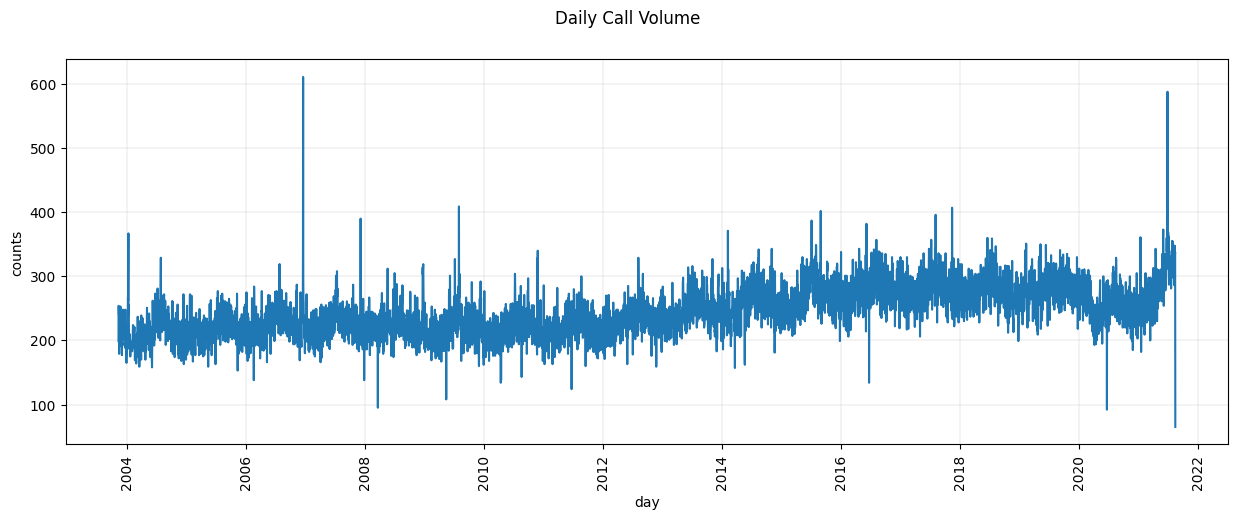

In [259]:
#Visualis the full dataset with Daily and Monthly Freq
plt.rcParams.update({"figure.figsize":(12,3), "figure.dpi": 300})
plt.style.use("default")
fig, ax = plt.subplots(1)
fig.set_figwidth(15)
fig.set_figheight(5)
sns.lineplot(data=dd, x="day", y="counts")
plt.grid(linestyle="-", linewidth=0.2)
plt.suptitle("Daily Call Volume")
ax.tick_params(axis="x", rotation=90)


In [279]:
#Outliers
dd[(dd.counts>380)].index
#dd[(dd.counts > 380) & (dd.counts < 120)]

DatetimeIndex(['2006-12-15', '2007-12-03', '2009-07-29', '2015-07-04',
               '2015-08-29', '2016-06-05', '2017-08-03', '2017-08-04',
               '2017-11-13', '2021-06-26', '2021-06-27', '2021-06-28',
               '2021-06-29'],
              dtype='datetime64[ns]', name='day', freq=None)

In [329]:
counts_daily = joint.groupby(joint.index.date).counts.sum()
temp_daily = joint.groupby(joint.index.date).temp_max.mean()
wind_speed_daily = joint.groupby(joint.index.date).wind_speed.mean()
weather_id_daily = joint.groupby(joint.index.date).weather_id.mean()

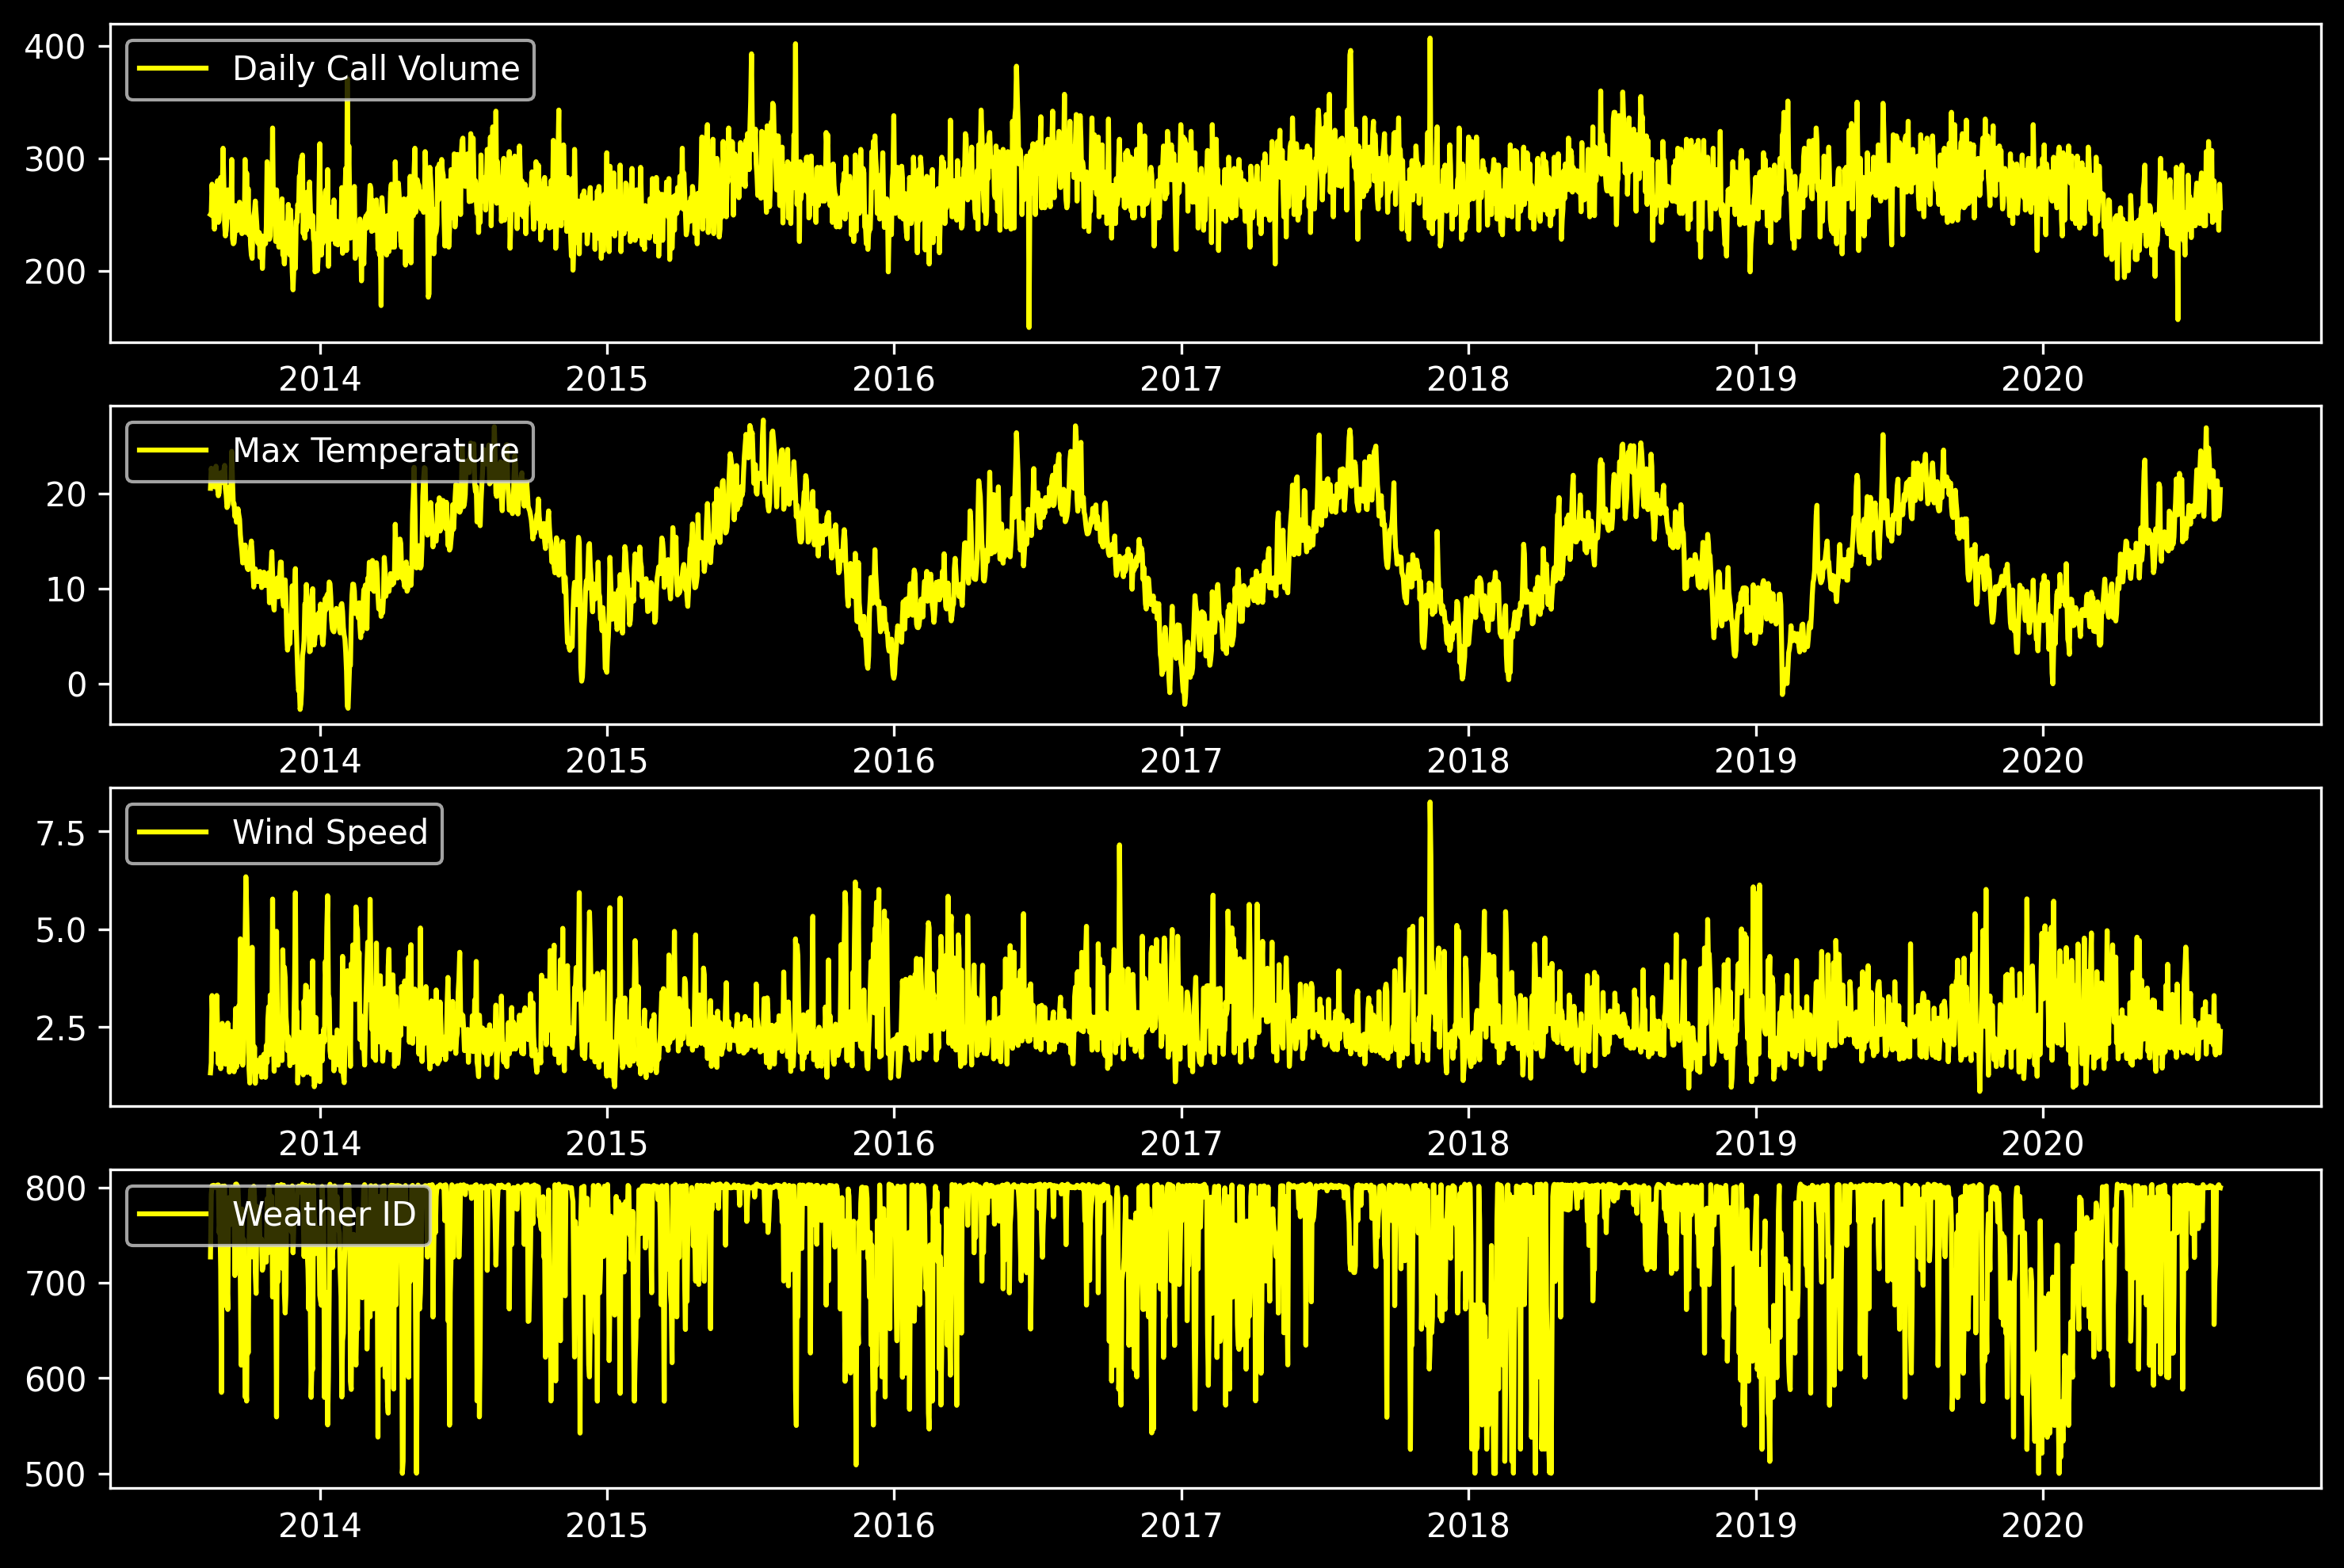

In [337]:
plt.rcParams.update({"figure.figsize":(12,3), "figure.dpi": 300})

plt.style.use('dark_background')
plt.figure(figsize=(12,8))
plt.subplot(411)
counts_daily.plot(label='Daily Call Volume', color='yellow')
plt.legend(loc='upper left')
plt.subplot(412)
temp_daily.plot(label='Max Temperature', color='yellow')
plt.legend(loc='upper left')
plt.subplot(413)
wind_speed_daily.plot(label='Wind Speed', color='yellow')
plt.legend(loc='upper left')
plt.subplot(414)
weather_id_daily.plot(label='Weather ID', color='yellow')
plt.legend(loc='upper left')

#sns.lineplot(data=joint, x=joint.index, y="counts")
#sns.lineplot(data=joint, x=joint.index, y="wind_speed")
#plt.grid(linestyle="-", linewidth=0.2)
#plt.suptitle("Daily Call Volume vs Weather Params")
#ax.tick_params(axis="x", rotation=90)

**Observations**
After looking at events for max and min outliers, one can infer that weather conditions like max temperature, wind_speed and weather_id are indicators of increment in call volume. So using them as features would improve the predictiona accuracy

In [340]:
cdf.index.min()

Timestamp('2003-11-07 09:30:48')

In [266]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposed = seasonal_decompose(dd.tail(1000)['counts'],  
                            model ='additive')

In [267]:
trend = decomposed.trend
seasonal = decomposed.seasonal
residual = decomposed.resid

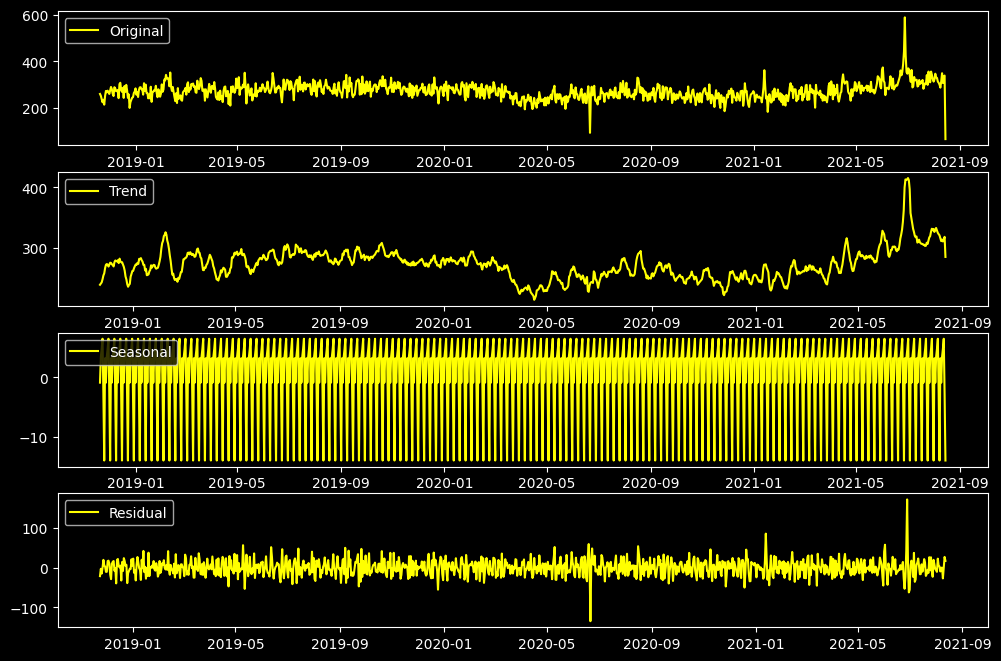

In [270]:
plt.style.use('dark_background')
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(dd.tail(1000), label='Original', color='yellow')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend', color='yellow')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal, label='Seasonal', color='yellow')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residual', color='yellow')
plt.legend(loc='upper left')
plt.show()